In [ ]:
!pip install  imageio
!pip install opencv-python
!pip install  git+https://github.com/tensorflow/docs

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import imageio
from IPython.display import HTML, display
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import keras
from keras.models import Sequential
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
KEYPOINT_DICT = {
    'nose': 0,'left_eye': 1,'right_eye': 2,'left_ear': 3,'right_ear': 4,'left_shoulder': 5,
    'right_shoulder': 6,'left_elbow': 7,'right_elbow': 8,'left_wrist': 9,'right_wrist': 10,
    'left_hip': 11,'right_hip': 12,'left_knee': 13,'right_knee': 14,'left_ankle': 15,
    'right_ankle': 16
}

KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',(0, 2): 'c',(1, 3): 'm',(2, 4): 'c',(0, 5): 'm',(0, 6): 'c',
    (5, 7): 'm',(7, 9): 'm',(6, 8): 'c',(8, 10): 'c',(5, 6): 'y',(5, 11): 'm',
    (6, 12): 'c',(11, 12): 'y',(11, 13): 'm',(13, 15): 'm',(12, 14): 'c',(14, 16): 'c'
}

In [ ]:
def _keypoints_and_edges_for_display(keypoints_with_scores,
         height,width,keypoint_threshold=0.11):

  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):

  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot


def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('/content/drive/MyDrive/Drunk_distraction/gif/animation.gif', images, fps=fps)
  return embed.embed_file('/content/drive/MyDrive/Drunk_distraction/gif/animation.gif')


def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [ ]:
model_name = "movenet_thunder_int8.tflite" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):

    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):

    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoint_with_scores = outputs['output_0'].numpy()
    return keypoint_with_scores

In [ ]:
def overlay(image):
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoint_with_scores = movenet(input_image)

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(
        display_image,128,128), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(
        np.squeeze(display_image.numpy(), axis=0), keypoint_with_scores)

    return output_overlay
def overlay2(image):
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoint_with_scores = movenet(input_image)

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(
        display_image, 128, 128), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(
        np.squeeze(display_image.numpy()*0, axis=0), keypoint_with_scores)

    return output_overlay

In [ ]:
data_dir='/content/drive/MyDrive/E-Learning Dataset/'
files=os.listdir(data_dir)
# print(files[0:5])

<class 'tensorflow.python.framework.ops.EagerTensor'>
(864, 864, 3)


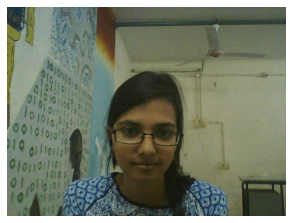

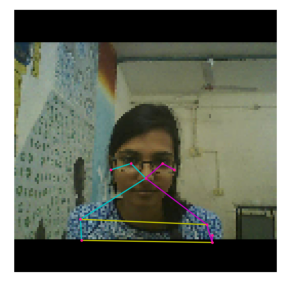

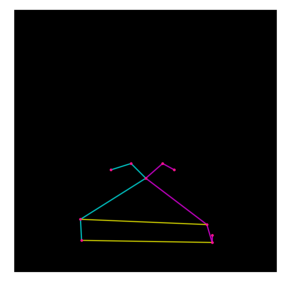

In [ ]:
paths=[]
# for item in files:
#     paths+=[os.path.join(data_dir,item)]
plt.figure(figsize=(5,5))
imageT0 = tf.io.read_file('/content/drive/MyDrive/E-Learning Dataset/train_frames/24851011_0.jpg')
imageT = tf.image.decode_jpeg(imageT0)
print(type(imageT))
plt.imshow(imageT)
_ = plt.axis('off')
plt.figure(figsize=(5,5))
#imageT0 = tf.io.read_file(image_path)
#imageT = tf.image.decode_jpeg(imageT0)
output_overlay=overlay(imageT)
print(np.shape(output_overlay))
plt.imshow(output_overlay)
_ = plt.axis('off')
plt.figure(figsize=(5,5))
#imageT0 = tf.io.read_file(image_path)
#imageT = tf.image.decode_jpeg(imageT0)
output_overlay=overlay2(imageT)
plt.imshow(output_overlay)
_ = plt.axis('off')

In [ ]:
import os
image_dir='/content/drive/MyDrive/E-Learning Dataset/train_frames/'
# save_dr='/content/drive/MyDrive/E-Learning Dataset/train_keypoints/'
save_dr='/content/drive/MyDrive/E-Learning Dataset/Train_keypoints_whole/'
files=os.listdir(image_dir)
print(len(files))
c0_t=[]
count=9
for i in range(len(files)):
        img=os.path.join(image_dir+files[i])
        name=img[:-6]
        name=name[55:]
        print(img)
        image=cv2.imread(img)
        input_image = tf.expand_dims(image, axis=0)
        input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
        keypoint_with_scores = movenet(input_image)
        img=np.reshape(keypoint_with_scores,(1,17,3))
        img_gray = np.mean(img, axis=2)
        c0_t.append(img_gray)
        if i==count:  
            c0_t=np.reshape(c0_t,(10,1,17))
            np.save(save_dr+name,c0_t)
            print(count)
            count=count+10
            c0_t=[]

            
        else:
              continue



Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/E-Learning Dataset/train_frames/1100041024_6.jpg
/content/drive/MyDrive/E-Learning Dataset/train_frames/1100041024_7.jpg
/content/drive/MyDrive/E-Learning Dataset/train_frames/1100041024_8.jpg
/content/drive/MyDrive/E-Learning Dataset/train_frames/1100041024_9.jpg
1009
/content/drive/MyDrive/E-Learning Dataset/train_frames/1100041034_0.jpg
/content/drive/MyDrive/E-Learning Dataset/train_frames/1100041034_1.jpg
/content/drive/MyDrive/E-Learning Dataset/train_frames/1100041034_2.jpg
/content/drive/MyDrive/E-Learning Dataset/train_frames/1100041034_3.jpg
/content/drive/MyDrive/E-Learning Dataset/train_frames/1100041034_4.jpg
/content/drive/MyDrive/E-Learning Dataset/train_frames/1100041034_5.jpg
/content/drive/MyDrive/E-Learning Dataset/train_frames/1100041034_6.jpg
/content/drive/MyDrive/E-Learning Dataset/train_frames/1100041034_7.jpg
/content/drive/MyDrive/E-Learning Dataset/train_frames/1100041034_8.jpg
/content

In [ ]:
# e='/content/drive/MyDrive/E-Learning Dataset/Train_keypoints_whole/'
# e_=os.listdir(e)
# print(len(e_))

In [ ]:
import os
image_dir='/content/drive/MyDrive/E-Learning Dataset/test_frames/'
save_dr='/content/drive/MyDrive/E-Learning Dataset/test_keypoints/'
files=os.listdir(image_dir)
print(len(files))
c0_t=[]
count=9
for i in range(len(files)):
        img=os.path.join(image_dir+files[i])
        name=img[:-6]
        name=name[59:]
        print(img)
        image=cv2.imread(img)
        input_image = tf.expand_dims(image, axis=0)
        input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
        keypoint_with_scores = movenet(input_image)
        img=np.reshape(keypoint_with_scores,(1,17,3))
        img_gray = np.mean(img, axis=2)
        c0_t.append(img_gray)
        if i==count:  
            c0_t=np.reshape(c0_t,(10,1,17))
            np.save(save_dr+name,c0_t)
            print(count)
            count=count+10
            c0_t=[]

            
        else:
              continue



In [ ]:
import os
image_dir='/content/drive/MyDrive/E-Learning Dataset/test_frames/'
save_dr='/content/drive/MyDrive/E-Learning Dataset/test_keypoints/'
files=os.listdir(image_dir)
print(len(files))
c0_t=[]
count=9
for i in range(len(files)):
        img=os.path.join(image_dir+files[i])
        name=img[:-6]
        name=name[59:]
        print(img)
        image=cv2.imread(img)
        input_image = tf.expand_dims(image, axis=0)
        input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
        keypoint_with_scores = movenet(input_image)
        img=np.reshape(keypoint_with_scores,(1,17,3))
        img_gray = np.mean(img, axis=2)
        c0_t.append(img_gray)
        if i==count:  
            c0_t=np.reshape(c0_t,(10,1,17))
            np.save(save_dr+name,c0_t)
            print(count)
            count=count+10
            c0_t=[]

            
        else:
              continue



13650
/content/drive/MyDrive/E-Learning Dataset/validation_frames/4000222045_0.jpg
/content/drive/MyDrive/E-Learning Dataset/validation_frames/4000222045_1.jpg
/content/drive/MyDrive/E-Learning Dataset/validation_frames/4000222045_2.jpg
/content/drive/MyDrive/E-Learning Dataset/validation_frames/4000222045_3.jpg
/content/drive/MyDrive/E-Learning Dataset/validation_frames/4000222045_4.jpg
/content/drive/MyDrive/E-Learning Dataset/validation_frames/4000222045_5.jpg
/content/drive/MyDrive/E-Learning Dataset/validation_frames/4000222045_6.jpg
/content/drive/MyDrive/E-Learning Dataset/validation_frames/4000222045_7.jpg
/content/drive/MyDrive/E-Learning Dataset/validation_frames/4000222045_8.jpg
/content/drive/MyDrive/E-Learning Dataset/validation_frames/4000222045_9.jpg
9
/content/drive/MyDrive/E-Learning Dataset/validation_frames/4000222044_0.jpg
/content/drive/MyDrive/E-Learning Dataset/validation_frames/4000222044_1.jpg
/content/drive/MyDrive/E-Learning Dataset/validation_frames/40002220

**Train and validation data into single numpy file**

In [ ]:
import os
train_path='/content/drive/MyDrive/E-Learning Dataset/test_keypoints/'
save_dir='/content/drive/MyDrive/E-Learning Dataset/'
num=os.listdir(train_path)
num=np.sort(num)
s=len(num)
print(num)
t_array=[]
print(len(num))
for i in range(len(num)):
    print(num[i])
    fle=np.load(os.path.join(train_path+num[i]))
    t_array.append(fle)
t_array=np.reshape(t_array,(s,17,10))
np.save(save_dir+'test_file',t_array)

['4000221001.npy' '4000221002.npy' '4000221006.npy' '4000221008.npy'
 '4000221009.npy' '4000221010.npy' '4000221011.npy' '4000221013.npy'
 '4000221014.npy' '4000221015.npy' '4000221016.npy' '4000221017.npy'
 '4000221018.npy' '4000221024.npy' '4000221033.npy' '4000221034.npy'
 '4000221035.npy' '4000221036.npy' '4000221040.npy' '4000221041.npy'
 '4000221042.npy' '4000221054.npy' '4000221055.npy' '4000221061.npy'
 '4000221062.npy' '4000221064.npy' '4000221065.npy' '4000221066.npy'
 '4000221067.npy' '4000221071.npy' '4000221072.npy' '4000222001.npy'
 '4000222003.npy' '4000222004.npy' '4000222007.npy' '4000222012.npy'
 '4000222013.npy' '4000222014.npy' '4000222015.npy' '4000222017.npy'
 '4000222031.npy' '4000222032.npy' '4000222035.npy' '4000222038.npy'
 '4000222044.npy' '4000222045.npy' '4000231001.npy' '4000231008.npy'
 '4000231010.npy' '4000231011.npy' '4000231012.npy' '4000231013.npy'
 '4000231014.npy' '4000231021.npy' '4000231032.npy' '4000231033.npy'
 '4000231034.npy' '4000231037.npy'

In [ ]:
import os
import numpy as np
train_path='/content/drive/MyDrive/E-Learning Dataset/Train_keypoints_whole/'
save_dir='/content/drive/MyDrive/E-Learning Dataset/'
num=os.listdir(train_path)
num=np.sort(num)
s=len(num)
t_array=[]
print(len(num))
for i in range(len(num)):
    # print(num[i])
    fle=np.load(os.path.join(train_path+num[i]))
    t_array.append(fle)
t_array=np.reshape(t_array,(s,17,10))
np.save(save_dir+'train_file',t_array)
        
     
 

In [ ]:
import os
import pandas as pd
df = pd.DataFrame()
df['y']=" "
output_loc=os.listdir('/content/drive/MyDrive/E-Learning Dataset/validation_keypoints/')
output_loc=np.sort(output_loc)
for i in output_loc:
            print(i)
            df=df.append({'Clip_id': i},ignore_index=True)
            df["y"][i]='0'
df.to_csv(r'/content/drive/MyDrive/E-Learning Dataset/vali_y.csv')  

In [ ]:
import os
import pandas as pd
df = pd.DataFrame()
df['y']=" "
output_loc=os.listdir('/content/drive/MyDrive/E-Learning Dataset/Train_keypoints_whole/')
output_loc=np.sort(output_loc)
for i in output_loc:
            print(i)
            df=df.append({'Clip_id': i},ignore_index=True)
            df["y"][i]='0'
df.to_csv(r'/content/drive/MyDrive/E-Learning Dataset/Train_y.csv') 

In [ ]:
import os
import pandas as pd
f=pd.read_csv('/content/drive/MyDrive/E-Learning Dataset/Labels/ValidationLabels.csv')
label=pd.read_csv('/content/drive/MyDrive/E-Learning Dataset/vali_y.csv')
v_id=f['ClipID']
im_id=label['Clip_id']
print(len(label))
for i in range(len(label)): 
      #  v_id=v_id[:-4]
      #  print("v_id",v_id[i])
      #  im_id=im_id[:-4]
      # #  print("im_id",im_id)
      #  if f.['ClipID'][i]==label.['Clip_id'][i]:
             print(i)
             class_b=f['Boredom']
             class_e=f['Engagement']
             class_c=f['Confusion']
             class_f=f['Frustration ']
             value_b=class_b.values[i]
             value_e=class_e.values[i]
             value_c=class_c.values[i]
             value_f=class_f.values[i]
             if value_b>0:
                   label['y'][i]='0'
                   print("Done")
             if value_e>0:
                  label['y'][i]='1'
             if value_c>0:
                    label['y'][i]='2'
             if value_f>0:
                    label['y'][i]='3'
             else:
                  continue
label.to_csv(r'/content/drive/MyDrive/E-Learning Dataset/vali_y.csv')


In [ ]:
import os
import pandas as pd
f=pd.read_csv('/content/drive/MyDrive/E-Learning Dataset/Labels/TrainLabels.csv')
label=pd.read_csv('/content/drive/MyDrive/E-Learning Dataset/Train_y.csv')
v_id=f['ClipID']
im_id=label['Clip_id']
print(len(label))
for i in range(len(label)): 
      #  v_id=v_id[:-4]
      #  print("v_id",v_id[i])
      #  im_id=im_id[:-4]
      # #  print("im_id",im_id)
      #  if f.['ClipID'][i]==label.['Clip_id'][i]:
             print(i)
             class_b=f['Boredom']
             class_e=f['Engagement']
             class_c=f['Confusion']
             class_f=f['Frustration ']
             value_b=class_b.values[i]
             value_e=class_e.values[i]
             value_c=class_c.values[i]
             value_f=class_f.values[i]
             if value_b>0:
                   label['y'][i]='0'
                   print("Done")
             if value_e>0:
                  label['y'][i]='1'
             if value_c>0:
                    label['y'][i]='2'
             if value_f>0:
                    label['y'][i]='3'
             else:
                  continue
label.to_csv(r'/content/drive/MyDrive/E-Learning Dataset/Train_y.csv')


In [ ]:
import os
import pandas as pd
f=pd.read_csv('/content/drive/MyDrive/E-Learning Dataset/Labels/TrainLabels.csv')
label=pd.read_csv('/content/drive/MyDrive/E-Learning Dataset/train_y.csv')
v_id=f['ClipID']
im_id=label['Clip_id']
print(len(label))
for i in range(len(label)): 
      
      #  v_id=v_id[:-4]
      #  print("v_id",v_id[i])
      #  im_id=im_id[:-4]
      # #  print("im_id",im_id)
      #  if f.['ClipID'][i]==label.['Clip_id'][i]:
             v_id=f['ClipID'][i]
             im_id=label['Clip_id'][i]
            #  print(v_id)
            #  print(im_id)
             v_id=v_id[:-4]
             im_id=im_id[:-4]
             if im_id==v_id:
                print(v_id)
                print(im_id)
                class_b=f['Boredom']
                class_e=f['Engagement']
                class_c=f['Confusion']
                class_f=f['Frustration ']
                value_b=class_b.values[i]
                value_e=class_e.values[i]
                value_c=class_c.values[i]
                value_f=class_f.values[i]
                if value_b>0:
                      label['y'][i]='0'
                if value_e>0:
                      label['y'][i]='1'
                if value_c>0:
                        label['y'][i]='2'
                if value_f>0:
                        label['y'][i]='3'
                else:
                      continue
# label.to_csv(r'/content/drive/MyDrive/E-Learning Dataset/train_y.csv')


In [ ]:
import numpy as np
import pandas as pd
X_train=np.load('/content/drive/MyDrive/E-Learning Dataset/train_file.npy')
Y_t=pd.read_csv('/content/drive/MyDrive/E-Learning Dataset/Train_y.csv')
y_train=Y_t['y']
X_test=np.load('/content/drive/MyDrive/E-Learning Dataset/validation_file.npy')
y_te=pd.read_csv('/content/drive/MyDrive/E-Learning Dataset/vali_y.csv')
y_test=y_te['y']

In [ ]:
Y_train=Y_t['y']
print(np.shape(Y_train))
Y_train=Y_train.astype(int)
print(Y_train)

In [ ]:
Y_test=y_te['y']
print(np.shape(Y_test))
print(Y_test)

In [ ]:
#  splitting into test and train

# from sklearn.model_selection  import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.20,shuffle=True,random_state=1)

In [ ]:
nsamples, nx, ny = X_train.shape
t_X_train = X_train.reshape((nsamples,nx*ny))
print(np.shape(t_X_train))

In [ ]:
nsamples, nx, ny = X_test.shape
t_X_test = X_test.reshape((nsamples,nx*ny))
print(np.shape(t_X_test))

**Plot_graph**

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
temp_list_accuracy=[]
temp_list_precision=[]
temp_list_recall=[]
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='lower right')
    plt.ylim([0,1])


**KNN**

In [ ]:
## 4 STEP MODELLING

# 1. import the class
from sklearn.neighbors import KNeighborsClassifier

# 2. instantiate the model (with the default parameters)
knn = KNeighborsClassifier()

# 3. fit the model with data (occurs in-place)
Kl=knn.fit(t_X_train, Y_train)

In [ ]:

from sklearn.metrics import  confusion_matrix, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import metrics
# predict class
y_pred_class = Kl.predict(t_X_test)
# predict probabilities
y_pred_proba =Kl.predict_proba(t_X_test)
accuracy=metrics.accuracy_score(Y_test, y_pred_class)
print("Accuracy:" ,accuracy)
confusion = metrics.confusion_matrix(Y_test, y_pred_class)
precision=precision_score(Y_test, y_pred_class, average='micro')
recall=recall_score(Y_test, y_pred_class, average='micro')
print("Precision",precision)
print("Recall",recall)
# print(confusion)

Accuracy: 0.717391304347826
Precision 0.717391304347826
Recall 0.717391304347826


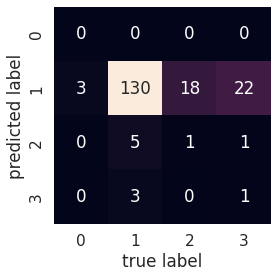

In [ ]:
#confusion matrix ploting
mat=confusion_matrix(Y_test, y_pred_class)
sns.set(font_scale=1.4)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');


**SVM**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

In [ ]:
from sklearn.metrics import precision_score
clf = svm.SVC(kernel='sigmoid', C=1,probability=True).fit(t_X_train, Y_train)
clf.score(t_X_test, Y_test)
y_pred_class2 = clf.predict(t_X_test)
accuracy=metrics.accuracy_score(Y_test, y_pred_class2)
confusion = metrics.confusion_matrix(Y_test, y_pred_class2)
precision=precision_score(Y_test, y_pred_class2, average='micro')
recall=recall_score(Y_test, y_pred_class2, average='micro')
print("Accuracy:" ,accuracy)
print("Precision",precision)
print("Recall",recall)
# print(confusion)



Accuracy: 0.75
Precision 0.75
Recall 0.75


In [ ]:
clf_l = svm.SVC(kernel='linear', C=1,probability=True).fit(t_X_train, Y_train)
clf_l.score(t_X_test, Y_test)
y_pred_class_3 = clf_l.predict(t_X_test)
accuracy2=metrics.accuracy_score(Y_test, y_pred_class_3)
confusion2 = metrics.confusion_matrix(Y_test, y_pred_class_3 )
precision2=precision_score(Y_test, y_pred_class_3, average='micro')
recall2=recall_score(Y_test, y_pred_class_3, average='micro')
print("precision",precision2)
print("Recall",recall2)
print("Accuracy",accuracy2)



precision 0.9787234042553191
Recall 1.0
Accuracy 0.75


In [ ]:
clf_poly = svm.SVC(kernel='poly', C=1,probability=True).fit(t_X_train, Y_train)
clf_poly.score(t_X_test, Y_test)
y_pred_class_4 = clf_poly.predict(t_X_test)
accuracy2=metrics.accuracy_score(Y_test, y_pred_class_4)
confusion2 = metrics.confusion_matrix(Y_test, y_pred_class_4)
precision2=precision_score(Y_test, y_pred_class_4, average='micro')
recall2=recall_score(Y_test, y_pred_class_4, average='micro')
print("precision",precision2)
print("Recall",recall2)
print("Accuracy",accuracy2)

precision 0.5869565217391305
Recall 0.5869565217391305
Accuracy 0.5869565217391305


In [ ]:
clf_rbf = svm.SVC(kernel='rbf', C=1,probability=True).fit(t_X_train, Y_train)
clf_rbf.score(t_X_test, Y_test)
y_pred_class5 =clf_rbf.predict(t_X_test)
accuracy2=metrics.accuracy_score(Y_test, y_pred_class5)
confusion2 = metrics.confusion_matrix(Y_test, y_pred_class5)
precision2=precision_score(Y_test, y_pred_class5, average='micro')
recall2=recall_score(Y_test, y_pred_class5, average='micro')
print("precision",precision2)
print("Recall",recall2)
print("Accuracy",accuracy2)

precision 0.9787234042553191
Recall 1.0
Accuracy 0.75


DEcision tree

In [ ]:
from sklearn import tree
clf_dt = tree.DecisionTreeClassifier(random_state=40)
clf_dt = clf.fit(t_X_train,Y_train)
clf_dt.score(t_X_test, Y_test)
y_pred_class_dt = clf.predict(t_X_test)
metrics.accuracy_score(Y_test, y_pred_class_dt)
accuracy2=metrics.accuracy_score(Y_test, y_pred_class_dt)
confusion3 = metrics.confusion_matrix(Y_test, y_pred_class_dt)
precision2=precision_score(Y_test, y_pred_class_dt, average='micro')
recall2=recall_score(Y_test, y_pred_class_dt, average='micro')
print("precision",precision2)
print("Recall",recall2)
print("Accuracy",accuracy2)

precision 0.75
Recall 0.75
Accuracy 0.75


In [ ]:
# Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_rf=RandomForestClassifier(n_estimators=100)
clf_rf.fit(t_X_train,Y_train)
y_pred=clf_rf.predict(t_X_test)
accuracy2=metrics.accuracy_score(Y_test, y_pred)
confusion3 = metrics.confusion_matrix(Y_test, y_pred)
precision2=precision_score(Y_test, y_pred, average='micro')
recall2=recall_score(Y_test, y_pred, average='micro')
print("precision",precision2)
print("Recall",recall2)
print("Accuracy",accuracy2)


precision 0.7065217391304348
Recall 0.7065217391304348
Accuracy 0.7065217391304348


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf12=RandomForestClassifier(n_estimators=45)
clf12.fit(t_X_train,Y_train)
y_pred12=clf12.predict(t_X_test)
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred12))
#confusion matrix ploting
confusion3 = metrics.confusion_matrix(Y_test, y_pred12)
print(confusion3)
accuracy2=metrics.accuracy_score(Y_test, y_pred12)
precision2=precision_score(Y_test, y_pred12, average='micro')
recall2=recall_score(Y_test, y_pred12, average='micro')
print("precision",precision2)
print("Recall",recall2)
print("Accuracy",accuracy2)



Accuracy: 0.7119565217391305
[[  0   3   0   0]
 [  0 130   1   7]
 [  0  19   0   0]
 [  0  23   0   1]]
precision 0.7119565217391305
Recall 0.7119565217391305
Accuracy 0.7119565217391305
